In [18]:
import h5py
import numpy as np
import os
import pandas as pd
from pathlib import Path
import scipy
import subprocess
import time

from os import listdir
from os.path import isfile, join

import matplotlib
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
import bacco
import bacco.probabilistic_bias as pb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Example straight from Jens

In [110]:
dir_name = "/scratch/cosmosims/Rings_Simulations/Nenya_N1536_L512/"

sim   = bacco.Simulation(basedir=dir_name + "0.00/",  halo_file="groups_030/fof_subhalo_history_tab_orph_wweight_030")

2024-01-19 18:42:04,895 bacco.sims : Initialising simulation Default
2024-01-19 18:42:04,896 bacco.sims : try /scratch/cosmosims/Rings_Simulations/Nenya_N1536_L512/0.00/groups_030/fof_subhalo_history_tab_orph_wweight_030
2024-01-19 18:42:04,931 bacco.sims : Loading /scratch/cosmosims/Rings_Simulations/Nenya_N1536_L512/0.00/groups_030/fof_subhalo_history_tab_orph_wweight_030
2024-01-19 18:42:04,944 bacco.cosmo :    initialization took 0.000 secs
2024-01-19 18:42:05,057 bacco.sims : ...done in 0.0504 s


In [111]:
# Define what variables we consider, "J2" means density and "J4" means Laplacian
variables = ("J2", "J4")
pbm = pb.ProbabilisticBiasManager(sim, variables=variables, damping_scale=0.15, ngrid=256) 

In [112]:
# Define what bias parameters we want to measure
# "J2" corresponds to b1, "J22" to b2, "J24" to bdeltaL, "J4" to bL, "J44" to bL**2
terms = ("J2", "J22", "J24", "J4", "J44")
model_expansion = pbm.setup_bias_model(pb.TensorBiasND, terms=terms, spatial_order=4)

2024-01-19 18:42:06,798 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.146 secs
2024-01-19 18:42:06,803 bacco.cosmo :    created Pk(z=0) tab from k 8.333333244081587e-05 to 100000.0 h/Mpc


In [113]:
# Define a set of tracers (here FoF groups selected by mass) and fit the bias. The error is estimate through a jackknife with 4**3 subboxes excluded one by one
m200b = sim.fof['halo_m200b'] * 1e10
mask =  ( np.log10(m200b) > 13.8 )  & ( np.log10(m200b) < 15.1 ) 
b, bcov = pbm.fit_bias(model=model_expansion, tracer_type="fof", mask=mask, error="jack4")

print("b1 = %.2f +- %.2f" % (b[0], np.sqrt(bcov[0,0])))
print("b2 = %.2f +- %.2f" % (b[1], np.sqrt(bcov[1,1])))

2024-01-19 18:42:18,270 bacco.sims : Reading 7902418 items for Group_M_Mean200
/tmp/ipykernel_223788/2828640615.py:3: RuntimeWarning: divide by zero encountered in log10
  mask =  ( np.log10(m200b) > 13.8 )  & ( np.log10(m200b) < 15.1 )
2024-01-19 18:42:21,878 bacco.sims : Reading 7902418 items for halo_firstsub
2024-01-19 18:42:23,696 bacco.sims : Reading 7902418 items for GroupNsubs
2024-01-19 18:42:25,442 bacco.sims : Reading 16313943 items for SnapBecameOrphan
2024-01-19 18:42:27,472 bacco.sims : Reading 16313943 items for SubhaloRankInGr
2024-01-19 18:42:31,469 bacco.sims : Reading 16313943 items for MostboundID
2024-01-19 18:42:33,861 bacco.sims : Reading 7902418 items for GroupLen


(1060, 3) (1060, 2)
b1 = 4.25 +- 0.31
b2 = 16.90 +- 3.54


Dope it works! just had to change np.bool --> bool

## let's try with quijote

Linear field

In [11]:
quijote_dir = '/dipc_storage/cosmosims/datashare/Quijote_data'

In [12]:
dens_yin = np.load(f'{quijote_dir}/Fiducial/ZA/200/den_200.npy')

In [49]:
box_size = 1000
ngrid = 512 

N-body sim

In [50]:
grid = bacco.visualization.uniform_grid(npix=ngrid, L=box_size, ndim=3, bounds=False)

In [51]:
sim_disp = np.load(f'{quijote_dir}/Fiducial/Quijote/200/dis_200.npy')

sim_pos = bacco.scaler.add_displacement(None,
                             sim_disp,
                             box=box_size,
                             pos=grid.reshape(-1,3),
                             vel=None,
                             vel_factor=0,
                             verbose=True)[0]

2024-01-19 17:14:31,808 bacco.scaler : Adding displacement field with a vel-factor=0.000000


### let's create a bias field with known bias params 

In [52]:
k_nyq = np.pi * ngrid / box_size

damping_scale = k_nyq

bmodel = bacco.BiasModel(sim=None, linear_delta=dens_yin[0], ngrid=ngrid, ngrid1=ngrid, 
                         sdm=True, mode="dm", BoxSize=box_size,
                         npart_for_fake_sim=ngrid, damping_scale=damping_scale, 
                         bias_model='expansion', deposit_method="cic", 
                         use_displacement_of_nn=False, interlacing=False, 
                         )

2024-01-19 17:14:33,038 bacco.BiasModel : Initialising Bias Model class ...


Ask the bias class to compute the bias fields in Lagrangian coordinates:

In [91]:
bias_terms_lag = bmodel.bias_terms_lag()

2024-01-19 18:26:17,605 bacco.BiasModel : Computing delta_to_tidal_field with 48 threads...
2024-01-19 18:26:17,606 bacco.BiasModel : fttw plan
2024-01-19 18:26:17,624 bacco.BiasModel : fttw freqs
2024-01-19 18:26:17,625 bacco.BiasModel : tidk freqs
2024-01-19 18:26:23,783 bacco.BiasModel : ifft
2024-01-19 18:26:56,327 bacco.BiasModel : Computing laplacian ...
2024-01-19 18:26:56,330 bacco.BiasModel : Memory used: 24.185503744 Gigabytes
2024-01-19 18:26:57,583 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2024-01-19 18:26:57,586 bacco.BiasModel : Memory used: 24.717221888 Gigabytes
2024-01-19 18:26:57,813 bacco.BiasModel : Computing delta squared ...
2024-01-19 18:26:57,814 bacco.BiasModel : Memory used: 25.254096896 Gigabytes
2024-01-19 18:26:59,055 bacco.BiasModel : Computing tidal component G2 with the given tidal field
2024-01-19 18:26:59,057 bacco.BiasModel : Memory used: 25.790971904 Gigabytes


In [92]:
bias_terms_lag.shape

(5, 512, 512, 512)

In [61]:
bias_terms_eul_sim=[]
for ii in range(0,len(bias_fields)):
    bias_terms_sim = bacco.statistics.compute_mesh(ngrid=ngrid, box=box_size, pos=sim_pos, 
                              mass = (bias_terms_lag[ii]).flatten(), deposit_method='cic', 
                              interlacing=False)
    bias_terms_eul_sim.append(bias_terms_sim)
bias_terms_eul_sim = np.array(bias_terms_eul_sim)

2024-01-19 17:46:02,054 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-01-19 17:46:02,055 bacco.statistics : starting deposit 1
2024-01-19 17:46:02,869 bacco.statistics :  mesh done in 0.814 s
2024-01-19 17:46:03,405 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-01-19 17:46:03,406 bacco.statistics : starting deposit 1
2024-01-19 17:46:04,178 bacco.statistics :  mesh done in 0.773 s
2024-01-19 17:46:04,657 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-01-19 17:46:04,658 bacco.statistics : starting deposit 1
2024-01-19 17:46:05,426 bacco.statistics :  mesh done in 0.768 s
2024-01-19 17:46:05,879 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-01-19 17:46:05,880 bacco.statistics : starting deposit 1
2024-01-19 17:46:06,794 bacco.statistics :  mesh done in 0.915 s
2024-01-19 17:46:07,254 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=Fal

In [68]:
bias_terms_eul_sim.shape

(5, 1, 512, 512, 512)

In [64]:
from bacco.utils import sum_bias_model_terms_py

In [83]:
bias_vector = [0.5, 0.5, 1.0, -1.0]
halo_field_eul = sum_bias_model_terms_py(zeroth=bias_terms_eul_sim[0], 
                                         first=bias_terms_eul_sim[1],
                                         second=bias_terms_eul_sim[2], 
                                         tidal=bias_terms_eul_sim[3], 
                                         laplacian=bias_terms_eul_sim[4], 
                                         b1=bias_vector[0], b2=bias_vector[1], 
                                         b3=bias_vector[2], b4=bias_vector[3], ngrid=ngrid)
#if self.mean_num_dens is not None:
    #Vcell = (self.BoxSize/self.ngrid)**3.
    #halo_field_eul = halo_field_eul*self.mean_num_dens*Vcell
norm=ngrid**3.
halo_field_eul_norm = halo_field_eul/norm

In [71]:
# looks like theres a direct function if i dont care about the individual fields
# bias_vector = [0.5, 0.5, 1.0, -1.0]
# halo_field_eul = bmodel.get_eul_bias_field(bias_vector, bias_terms_lagrangian=bias_fields)

In [84]:
halo_field_eul.shape

(512, 512, 512)

In [85]:
print(bias_terms_eul_sim[0][0][0,0,:10])
print(halo_field_eul[0,0,:10])

[0.8979322  0.13886973 0.         0.08160638 0.48559746 0.43586278
 0.00380634 0.07616333 0.18782741 0.05929425]
[ 1.5745705   1.2264574   0.         -0.54167646 -1.4181274  -0.61939144
  0.00170922  0.6812594   1.5069001   0.6962192 ]


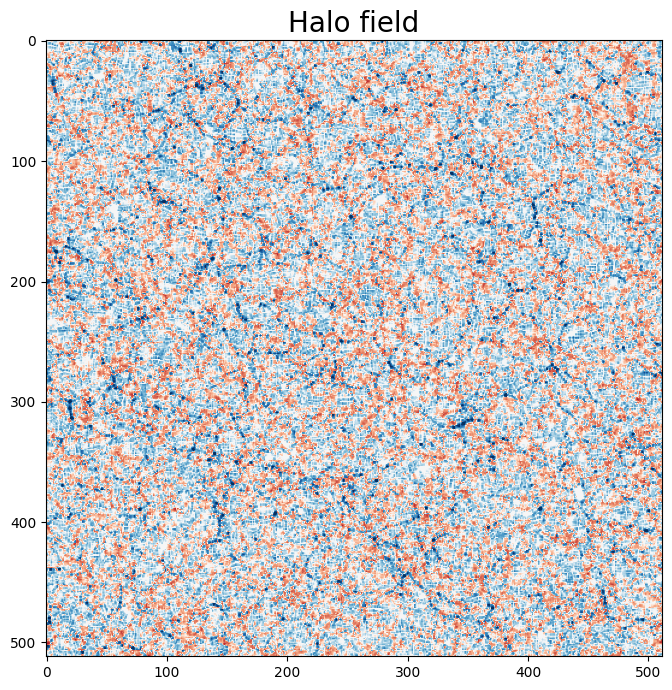

In [90]:
from matplotlib.colors import SymLogNorm
norm = SymLogNorm(linthresh=0.1, linscale=0.1, vmin=-100.0, vmax=100.0)

#Plot 1-term
plt.figure(figsize=(8,8))
plt.imshow(halo_field_eul[0,:,:], norm=norm, cmap='RdBu')
#plt.imshow(halo_field_eul[0,:,:])
#plt.colorbar()
plt.title(r'Halo field', size=20)
plt.show()

and in lagrangian space:

In [94]:
halo_field_lag = sum_bias_model_terms_py(zeroth=bias_terms_lag[0], 
                                         first=bias_terms_lag[1],
                                         second=bias_terms_lag[2], 
                                         tidal=bias_terms_lag[3], 
                                         laplacian=bias_terms_lag[4], 
                                         b1=bias_vector[0], b2=bias_vector[1], 
                                         b3=bias_vector[2], b4=bias_vector[3], ngrid=ngrid)

## and back to the prob bias:

In [98]:
variables = ("J2", "J4")
pbm = pb.ProbabilisticBiasManager(None, variables=variables, damping_scale=0.15, ngrid=ngrid,
                                 tocache=(), # jens told me not to cache things when loading in my own sim
                                 ) 

In [99]:
# TODO i think im supposed to do the smoothing myself in this case? see jens slack message
pbm.setup_linear_fields(ngrid=pbm.ngrid, damping_scale=pbm.damping_scale, kmin=pbm.kmin, kmax=pbm.kmax,
                        delta=dens_yin, box_size=box_size)

In [100]:
pbm.fields_initialized

True

Cool it knew that we initialized the fields, so we can still call pbm.setup_bias_model as before:

In [101]:
# "J2" corresponds to b1, "J22" to b2, "J24" to bdeltaL, "J4" to bL, "J44" to bL**2
terms = ("J2", "J22", "J24", "J4", "J44")
model_expansion = pbm.setup_bias_model(pb.TensorBiasND, terms=terms, spatial_order=4)

In [114]:
tracer_q = halo_field_lag.T
# TODO ok this should have shape N,3 - so need actual positions, not on a grid
# tracer_value has shape N,2 (not clear on why...)

In [108]:
tracer_q.shape

(512, 512, 512)

In [109]:
# looked thru code, reproducing here to be able to do without a sim
dm_field_ip = pbm._create_interpolator(pbm.dm_field)
tracer_value = dm_field_ip(tracer_q)

ValueError: The requested sample points xi have dimension 512 but this RegularGridInterpolator has dimension 3

In [ ]:
b, bcov = pbm.fit_bias(model=model_expansion, tracer_q=tracer_q, tracer_value=tracer_value,
                       mask=None, error="jack4")

print("b1 = %.2f +- %.2f" % (b[0], np.sqrt(bcov[0,0])))
print("b2 = %.2f +- %.2f" % (b[1], np.sqrt(bcov[1,1])))